In [1]:
import torch
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch import nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import random

2.2.1+cu121


In [2]:
df = pd.read_csv('../fyp_data/smooth_df.csv')

date_column = 'Date'
date_number_column = 'Date Number'
ili_rate_column = 'ILI Rate'
query_columns = [col for col in df.columns if col not in [date_column, date_number_column, ili_rate_column]]

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [3]:
def custom_time_series_split(df, date_column):
    # Custom time series split based on years
    years = df[date_column].dt.year.unique()
    splits = [(years[5], years[i]) for i in range(10, len(years) - 4)]
    return splits

def get_train_test_split_data(X_shifted, y_shifted, X, y, train_start_date, test_start_date, test_end_date, corr_start_date):
    # Get the training and test data for a specific split
    train_indices = (X_shifted[date_column] >= train_start_date) & (X_shifted[date_column] < test_start_date)
    test_indices = (X_shifted[date_column] >= test_start_date) & (X_shifted[date_column] <= test_end_date)
    corr_indices = (X_shifted[date_column] >= corr_start_date) & (X_shifted[date_column] < test_start_date)

    X_train, y_train = X_shifted[train_indices], y_shifted[train_indices]
    X_test, y_test = X_shifted[test_indices], y_shifted[test_indices]
    X_corr, y_corr = X_shifted[corr_indices], y_shifted[corr_indices]

    return (X_train.iloc[:, 1:], y_train, X_test.iloc[:, 1:], y_test, X_corr.iloc[:, 1:], y_corr)

def min_max_data(X_train, X_test):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    return X_train_scaled, X_test_scaled

def create_lagged_features(df, n_lags):
    lagged_dfs = [df]
    for lag in range(1, n_lags + 1):
        lagged_df = df.shift(lag)
        lagged_df = lagged_df.add_suffix(f'_t-{lag}')
        lagged_dfs.append(lagged_df)

    all_lagged_df = pd.concat(lagged_dfs, axis=1)
    all_lagged_df = all_lagged_df.dropna()
    return all_lagged_df

def create_lagged_features_with_overlap(X_train, y_train, X_test, n_lags=13):
    X_train_lagged = create_lagged_features(X_train, n_lags)
    y_train = y_train.iloc[n_lags:]

    X_test = pd.concat([X_train.iloc[-n_lags:], X_test], ignore_index=True)
    X_test_lagged = create_lagged_features(X_test, n_lags)

    return X_train_lagged.values, y_train, X_test_lagged.values

def convert_to_tensor(X_train, y_train, X_test, y_test):
    return (
        torch.FloatTensor(X_train), torch.FloatTensor(y_train.values), torch.FloatTensor(X_test), torch.FloatTensor(y_test.values)
    )

In [4]:
def get_correlation_df(X_corr, y_corr):
    correlation_scores = []
    for query_column in X_corr.columns:
        correlation = y_corr.corr(X_corr[query_column])
        correlation_scores.append((query_column, correlation))
    return pd.DataFrame(correlation_scores, columns=['Query', 'Correlation'])

def correlation_based_feature_selection(X_corr, y_corr, X_train, X_test, threshold):
    correlation_df = get_correlation_df(X_corr, y_corr).sort_values(by='Correlation', ascending=False).reset_index(drop=True)
    relevant_queries = correlation_df[correlation_df['Correlation'] >= threshold]['Query'].to_list()

    X_train = X_train[relevant_queries]
    X_test = X_test[relevant_queries]

    print("number of features after correlation based fs: ", X_train.shape[1])
    print("X_train: ", X_train.shape, "X_test: ", X_test.shape)

    return X_train, X_test

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 4)
        self.fc2 = nn.Linear(4, 1)
        self.dropout = nn.Dropout(0)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def create_ffnn(X_train, seed):
    torch.manual_seed(seed)
    return SimpleNN(X_train.shape[1]).to(device)

In [6]:
def train_neural_network(model, X_train, y_train, X_test, y_test, test_start_year, epochs=200, learning_rate=0.001, patience=15):
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=14, shuffle=False)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=14, shuffle=False)

    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, targets)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader))

        # Test phase
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze(1)
                test_loss += criterion(outputs, targets).item()
            test_loss /= len(test_loader)
            test_losses.append(test_loss)

    # plt.figure(figsize=(10, 6))
    # plt.plot(train_losses, label='Training Loss')
    # plt.plot(test_losses, label='Test Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title(f'Training and Validation Losses {test_start_year}-{test_start_year+1}')
    # plt.legend()
    # plt.show()

    return (model, epoch+1, train_losses, test_losses)


def evaluate_neural_network(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        y_pred = model(X_test)


        y_pred_cpu = y_pred.cpu().detach().numpy().flatten()
        y_test_cpu = y_test.cpu().numpy().flatten()

        print("y_pred: ", y_pred_cpu[0:5])

        mae = mean_absolute_error(y_test_cpu, y_pred_cpu)
        mape = np.mean(np.abs((y_test_cpu - y_pred_cpu) / y_test_cpu)) * 100
        pearson_corr, _ = pearsonr(y_test_cpu, y_pred_cpu)
        print("MAE: ", mae, "MAPE: ", mape, "P: ", pearson_corr)

    return y_pred_cpu, mae, mape, pearson_corr

In [7]:
def add_average_row(model_performance):
    mae_avg = np.mean(model_performance['MAE'])
    pearson_corr_avg = np.mean(model_performance['Pearson_Correlation'])
    mape_avg = np.mean(model_performance['MAPE'])
    print("MAE AVG: ", mae_avg, "MAPE AVG: ", mape_avg, "P AVG: ", pearson_corr_avg, "\n\n")

    model_performance.loc[len(model_performance)] = {
        'Year': 'Average',
        'MAE': mae_avg,
        'MAPE': mape_avg,
        'Pearson_Correlation': pearson_corr_avg
    }

def run_neural_network(queries, threshold):
    X = df[[date_column] + queries]
    y = df[ili_rate_column]

    forecasting_horizon = 7
    y_shifted = y.shift(-forecasting_horizon)
    y_shifted = y_shifted.iloc[:-forecasting_horizon]
    X_shifted = X.iloc[:-forecasting_horizon]

    splits = custom_time_series_split(df, date_column)
    
    seed_train_losses = {}
    seed_test_losses = {}

    seed_performances = []
    seed_predictions = []

    seeds = [9904, 5727, 4644, 2955, 3021, 3094, 8349, 5566, 1564, 1723]

    for seed in seeds:
        print("SEED: ", seed)

        model_performance = pd.DataFrame(columns=['Year', 'MAE', 'MAPE', 'Pearson_Correlation'])
        model_predictions = pd.DataFrame(columns=['Date', 'Actual_ILI_Rate', 'Predicted_ILI_Rate'])

        for train_start_year, test_start_year in splits:
            if (test_start_year, test_start_year+1) not in seed_train_losses:
                seed_train_losses[(test_start_year, test_start_year+1)] = []
                seed_test_losses[(test_start_year, test_start_year+1)] = []

            train_start_date = f'{train_start_year}-09-01'
            test_start_date = f'{test_start_year}-09-01'
            test_end_date = f'{test_start_year+1}-08-31'
            corr_start_date = f'{test_start_year-5}-09-01'

            print("train_start_date: ", train_start_date, "test_start_date: ", test_start_date, "test_end_date: ", test_end_date)

            X_train, y_train, X_test, y_test, X_corr, y_corr = get_train_test_split_data(X_shifted, y_shifted, X, y, train_start_date, test_start_date, test_end_date, corr_start_date)
            X_train, X_test = correlation_based_feature_selection(X_corr, y_corr, X_train, X_test, threshold)
            X_train, X_test = min_max_data(X_train, X_test)
            # X_train, y_train, X_test = create_lagged_features_with_overlap(X_train, y_train, X_test)
            X_train, y_train, X_test, y_test = convert_to_tensor(X_train.values, y_train, X_test.values, y_test)

            model, epochs, train_losses, test_losses = train_neural_network(create_ffnn(X_train, seed), X_train, y_train, X_test, y_test, test_start_year)
            seed_train_losses[(test_start_year, test_start_year+1)].append(train_losses)
            seed_test_losses[(test_start_year, test_start_year+1)].append(test_losses)
            y_pred, mae, mape, pearson_corr = evaluate_neural_network(model, X_test, y_test)

            model_performance.loc[len(model_performance)] = {
                'Year': f'{test_start_year}-{test_start_year+1}',
                'MAE': mae,
                'MAPE': mape,
                'Pearson_Correlation': pearson_corr,
            }

            date_range = pd.date_range(start=f'{test_start_year}-09-{forecasting_horizon+1}', periods=len(y_pred))
            iteration_predictions = pd.DataFrame({
                'Date': date_range,
                'Predicted_ILI_Rate': y_pred,
                'Actual_ILI_Rate': y_test.cpu().numpy().flatten()
            })
            model_predictions = pd.concat([model_predictions, iteration_predictions])

        add_average_row(model_performance)

        seed_performances.append(model_performance)
        seed_predictions.append(model_predictions)

    avg_performance = pd.concat(seed_performances).groupby(['Year']).agg({'MAE': ['mean', 'std'], 'Pearson_Correlation': ['mean', 'std'], 'MAPE': ['mean', 'std']}).reset_index().round(5)
    avg_predictions = pd.concat(seed_predictions).groupby(['Date']).mean().reset_index()

    for test_start_year, test_end_year in seed_train_losses.keys():
        mean_train_losses = np.mean(np.array(seed_train_losses[(test_start_year, test_end_year)]), axis=0)
        mean_test_losses = np.mean(np.array(seed_test_losses[(test_start_year, test_end_year)]), axis=0)

        plt.figure(figsize=(10, 6))
        plt.plot(mean_train_losses, label='Training Loss')
        plt.plot(mean_test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Losses {test_start_year}-{test_start_year+1}')
        plt.legend()
        plt.show()

    return avg_performance, avg_predictions

SEED:  9904
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  311
X_train:  (1826, 311) X_test:  (365, 311)


y_pred:  [2.556319  2.9978943 2.213933  2.2898643 2.40317  ]
MAE:  1.2248632 MAPE:  20.30237913131714 P:  0.9533595487094687
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  301
X_train:  (2191, 301) X_test:  (366, 301)


/tmp/ipykernel_1689559/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.7804304 1.6120728 2.4359763 2.220697  2.0411646]
MAE:  1.444798 MAPE:  18.707509338855743 P:  0.9368345053726618
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  369
X_train:  (2557, 369) X_test:  (365, 369)
y_pred:  [2.2810013 2.2626982 2.1297557 2.0237458 2.3358965]
MAE:  2.1676738 MAPE:  45.785313844680786 P:  0.934353923168017
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  364
X_train:  (2922, 364) X_test:  (365, 364)
y_pred:  [2.0091524 2.2774272 2.4671757 2.7335756 2.4374852]
MAE:  2.2625709 MAPE:  20.71324586868286 P:  0.9791185478156672
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  397
X_train:  (3287, 397) X_test:  (365, 397)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.6790483 1.2463623 1.1593568 1.5010221 2.4050646]
MAE:  1.8411263 MAPE:  44.12715435028076 P:  0.9411787908724011
MAE AVG:  1.7882063 MAPE AVG:  29.92712050676346 P AVG:  0.9489690631876432 


SEED:  5727
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  311
X_train:  (1826, 311) X_test:  (365, 311)
y_pred:  [2.2625434 3.2152739 2.070522  1.9969676 2.2028296]
MAE:  1.2414018 MAPE:  20.941488444805145 P:  0.9526630377499699
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  301
X_train:  (2191, 301) X_test:  (366, 301)


/tmp/ipykernel_1689559/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.0726873 0.9543215 2.0603962 1.8501035 1.7831167]
MAE:  1.5773432 MAPE:  22.647182643413544 P:  0.9362313239107025
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  369
X_train:  (2557, 369) X_test:  (365, 369)
y_pred:  [2.350116  2.4499674 2.1989758 2.0329578 2.411901 ]
MAE:  2.138329 MAPE:  46.3585764169693 P:  0.939650941902057
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  364
X_train:  (2922, 364) X_test:  (365, 364)
y_pred:  [2.1307921 2.2849467 2.6881275 2.8308225 2.7188764]
MAE:  1.8703837 MAPE:  20.454640686511993 P:  0.9859049779210833
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  397
X_train:  (3287, 397) X_test:  (365, 397)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.780884  1.3912798 1.3278358 1.6859848 2.5970926]
MAE:  1.8744769 MAPE:  45.900627970695496 P:  0.9422039184544974
MAE AVG:  1.740387 MAPE AVG:  31.260503232479095 P AVG:  0.9513308399876619 


SEED:  4644
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  311
X_train:  (1826, 311) X_test:  (365, 311)
y_pred:  [2.5463297 3.0147781 2.1904995 2.283244  2.364553 ]
MAE:  1.221264 MAPE:  20.170079171657562 P:  0.9537840869761872
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  301
X_train:  (2191, 301) X_test:  (366, 301)


/tmp/ipykernel_1689559/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.078548   0.96581507 1.9499077  1.8010758  1.7090718 ]
MAE:  1.6287042 MAPE:  21.77026718854904 P:  0.9372691178118684
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  369
X_train:  (2557, 369) X_test:  (365, 369)
y_pred:  [2.092017  2.6395051 1.9254216 0.9413547 1.8462385]
MAE:  2.443433 MAPE:  63.11745643615723 P:  0.9410626815350598
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  364
X_train:  (2922, 364) X_test:  (365, 364)
y_pred:  [1.7350572 1.9912599 2.8397236 3.0755699 3.1022596]
MAE:  2.4775481 MAPE:  28.66933047771454 P:  0.9857893226948221
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  397
X_train:  (3287, 397) X_test:  (365, 397)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.9937382 1.9359586 1.8515565 2.066705  2.4100084]
MAE:  1.1822771 MAPE:  28.362157940864563 P:  0.962946285259066
MAE AVG:  1.7906452 MAPE AVG:  32.417858242988586 P AVG:  0.9561702988554007 


SEED:  2955
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  311
X_train:  (1826, 311) X_test:  (365, 311)
y_pred:  [2.2427828 3.3380265 2.0901918 1.9505515 2.164353 ]
MAE:  1.2541816 MAPE:  21.517010033130646 P:  0.9513192939194318
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  301
X_train:  (2191, 301) X_test:  (366, 301)


/tmp/ipykernel_1689559/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.112526  0.9431077 2.005888  1.8732263 1.6920816]
MAE:  1.6018853 MAPE:  22.36449420452118 P:  0.9366276200390976
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  369
X_train:  (2557, 369) X_test:  (365, 369)
y_pred:  [2.2916238 2.3956788 2.1727533 2.0080519 2.3678374]
MAE:  2.0554433 MAPE:  42.13031530380249 P:  0.9403090360639644
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  364
X_train:  (2922, 364) X_test:  (365, 364)
y_pred:  [1.9080907 2.1668973 2.3238552 2.648152  2.3319173]
MAE:  2.3151062 MAPE:  21.730627119541168 P:  0.9829863251727418
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  397
X_train:  (3287, 397) X_test:  (365, 397)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.8867366 1.9036114 1.8606324 2.0320134 2.1798396]
MAE:  1.1683751 MAPE:  26.197412610054016 P:  0.9603047138965263
MAE AVG:  1.6789984 MAPE AVG:  26.7879718542099 P AVG:  0.9543093978183524 


SEED:  3021
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  311
X_train:  (1826, 311) X_test:  (365, 311)
y_pred:  [5.234507 5.234507 5.234507 5.234507 5.234507]
MAE:  4.2749186 MAPE:  79.37889695167542 P:  nan
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  301
X_train:  (2191, 301) X_test:  (366, 301)


/tmp/ipykernel_1689559/3281515322.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(y_test_cpu, y_pred_cpu)
/tmp/ipykernel_1689559/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.0763044 0.9767332 1.9516692 1.7928545 1.6790981]
MAE:  1.6328074 MAPE:  21.534232795238495 P:  0.9372541126520038
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  369
X_train:  (2557, 369) X_test:  (365, 369)
y_pred:  [2.4171097 2.3468766 2.1162508 2.023536  2.5191991]
MAE:  2.0523148 MAPE:  42.59399473667145 P:  0.9345514360547065
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  364
X_train:  (2922, 364) X_test:  (365, 364)
y_pred:  [1.6233923 1.950676  2.7420363 3.013071  2.9140613]
MAE:  2.5741832 MAPE:  32.33320116996765 P:  0.9853279420889779
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  397
X_train:  (3287, 397) X_test:  (365, 397)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.9714168 1.8795462 1.8147885 1.9911515 2.6550822]
MAE:  1.3391777 MAPE:  33.1546813249588 P:  0.9611928738098799
MAE AVG:  2.3746803 MAPE AVG:  41.79900139570236 P AVG:  0.9545815911513921 


SEED:  3094
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  311
X_train:  (1826, 311) X_test:  (365, 311)
y_pred:  [2.2807841 3.1548862 2.0632796 1.9914544 2.1554365]
MAE:  1.2447307 MAPE:  20.97148597240448 P:  0.9526255343953226
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  301
X_train:  (2191, 301) X_test:  (366, 301)


/tmp/ipykernel_1689559/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.2243172 1.0596312 2.3797133 2.1220264 1.7917155]
MAE:  1.564828 MAPE:  23.59614074230194 P:  0.9319833648403748
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  369
X_train:  (2557, 369) X_test:  (365, 369)
y_pred:  [2.2407463 2.290064  1.96633   1.5648327 2.1101663]
MAE:  2.0570867 MAPE:  49.294015765190125 P:  0.9418693618143948
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  364
X_train:  (2922, 364) X_test:  (365, 364)
y_pred:  [2.1392555 2.274269  2.6323478 2.8495338 2.6503775]
MAE:  1.9236516 MAPE:  20.288220047950745 P:  0.9846130790996034
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  397
X_train:  (3287, 397) X_test:  (365, 397)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.9614928 2.0128207 1.8717182 2.139784  2.2341552]
MAE:  1.0744265 MAPE:  22.591738402843475 P:  0.9632829738306898
MAE AVG:  1.5729449 MAPE AVG:  27.348320186138153 P AVG:  0.9548748627960771 


SEED:  8349
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  311
X_train:  (1826, 311) X_test:  (365, 311)
y_pred:  [2.4954548 3.093772  2.182743  2.1844938 2.3307087]
MAE:  1.2281193 MAPE:  20.505337417125702 P:  0.9529324625762716
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  301
X_train:  (2191, 301) X_test:  (366, 301)


/tmp/ipykernel_1689559/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.1105752  0.99034995 1.973855   1.811058   1.6887777 ]
MAE:  1.6356919 MAPE:  21.84944599866867 P:  0.9370895737924169
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  369
X_train:  (2557, 369) X_test:  (365, 369)
y_pred:  [2.4189458 2.464342  2.169197  2.019136  2.4902687]
MAE:  2.1313055 MAPE:  47.002112865448 P:  0.9354827793852583
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  364
X_train:  (2922, 364) X_test:  (365, 364)
y_pred:  [2.1822422 2.3325498 2.7350347 2.8702307 2.7441564]
MAE:  1.9212371 MAPE:  20.993949472904205 P:  0.985828785873081
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  397
X_train:  (3287, 397) X_test:  (365, 397)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.8308307 1.3822675 1.2659433 1.7211057 2.5567586]
MAE:  1.8555624 MAPE:  44.81991231441498 P:  0.9417634426122086
MAE AVG:  1.7543831 MAPE AVG:  31.03415161371231 P AVG:  0.9506194088478473 


SEED:  5566
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  311
X_train:  (1826, 311) X_test:  (365, 311)
y_pred:  [2.185898  3.5289676 2.1214228 1.9670029 2.205592 ]
MAE:  1.2622381 MAPE:  21.804700791835785 P:  0.949855244446674
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  301
X_train:  (2191, 301) X_test:  (366, 301)


/tmp/ipykernel_1689559/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.1406684 0.9630775 2.0245676 1.8801627 1.6870308]
MAE:  1.5978628 MAPE:  22.274376451969147 P:  0.9369379464101844
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  369
X_train:  (2557, 369) X_test:  (365, 369)
y_pred:  [2.1404483 2.5435107 1.9201248 1.0273559 1.9404402]
MAE:  2.3991091 MAPE:  62.14321851730347 P:  0.9389357675531965
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  364
X_train:  (2922, 364) X_test:  (365, 364)
y_pred:  [2.0089784 2.2226434 2.441024  2.7300925 2.4471462]
MAE:  2.1635416 MAPE:  20.5119326710701 P:  0.9833566648311682
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  397
X_train:  (3287, 397) X_test:  (365, 397)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.7453218 1.3454828 1.2803936 1.5470667 2.5372648]
MAE:  1.9153464 MAPE:  46.75203859806061 P:  0.9417773832521545
MAE AVG:  1.8676195 MAPE AVG:  34.69725340604782 P AVG:  0.9501726012986754 


SEED:  1564
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  311
X_train:  (1826, 311) X_test:  (365, 311)
y_pred:  [2.162034  3.5181856 2.1118402 2.0099988 2.1780577]
MAE:  1.255301 MAPE:  21.67525142431259 P:  0.9501155778521926
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  301
X_train:  (2191, 301) X_test:  (366, 301)


/tmp/ipykernel_1689559/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.129607  0.9216825 2.0767224 1.9198364 1.7085329]
MAE:  1.589031 MAPE:  22.239188849925995 P:  0.9367270256374896
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  369
X_train:  (2557, 369) X_test:  (365, 369)
y_pred:  [2.183259  2.2976623 2.1892083 2.041678  2.2482889]
MAE:  2.014142 MAPE:  38.539716601371765 P:  0.9326956417378828
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  364
X_train:  (2922, 364) X_test:  (365, 364)
y_pred:  [2.1043832 2.2273865 2.3849702 2.3952346 2.3256443]
MAE:  2.1146715 MAPE:  18.583737313747406 P:  0.9784280623889673
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  397
X_train:  (3287, 397) X_test:  (365, 397)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.9332888 1.879362  1.7786219 1.9664843 2.6543975]
MAE:  1.3351638 MAPE:  33.14325511455536 P:  0.9612176573724518
MAE AVG:  1.6616619 MAPE AVG:  26.836229860782623 P AVG:  0.9518367929977968 


SEED:  1723
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  311
X_train:  (1826, 311) X_test:  (365, 311)
y_pred:  [2.5439181 3.0492802 2.1630654 2.2123075 2.3549714]
MAE:  1.215315 MAPE:  20.40151059627533 P:  0.9539276706096262
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  301
X_train:  (2191, 301) X_test:  (366, 301)


/tmp/ipykernel_1689559/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.0886352 0.9699531 1.955385  1.7536869 1.6932425]
MAE:  1.6358744 MAPE:  21.50561660528183 P:  0.9373250534635603
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  369
X_train:  (2557, 369) X_test:  (365, 369)
y_pred:  [2.0369782 2.5225282 1.8724004 0.9827328 1.9105866]
MAE:  2.3981981 MAPE:  61.70121431350708 P:  0.9386285096664788
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  364
X_train:  (2922, 364) X_test:  (365, 364)
y_pred:  [2.1069467 2.2695491 2.638151  2.8084214 2.6046627]
MAE:  1.9877346 MAPE:  20.470401644706726 P:  0.9853242529240297
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  397
X_train:  (3287, 397) X_test:  (365, 397)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [5.2663517 5.2663517 5.2663517 5.2663517 5.2663517]
MAE:  4.4170394 MAPE:  109.51255559921265 P:  nan
MAE AVG:  2.3308322 MAPE AVG:  46.71825975179672 P AVG:  0.9538013716659237 




/tmp/ipykernel_1689559/3281515322.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(y_test_cpu, y_pred_cpu)


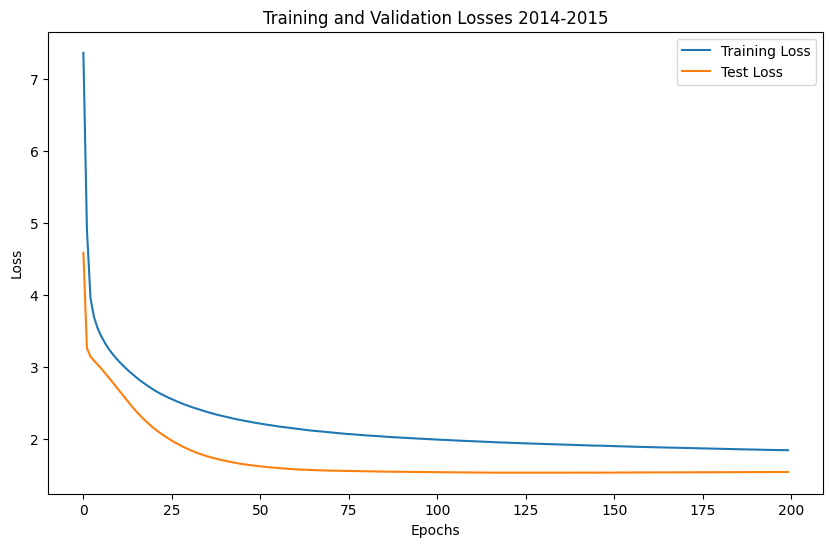

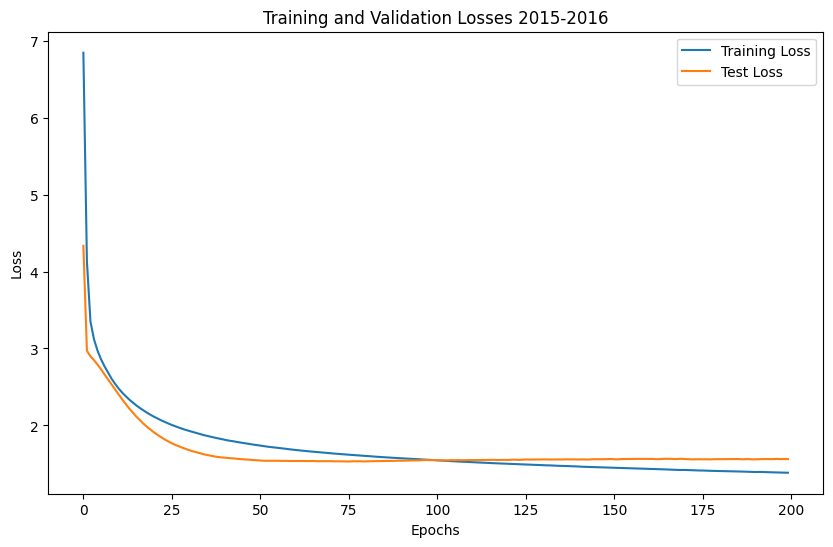

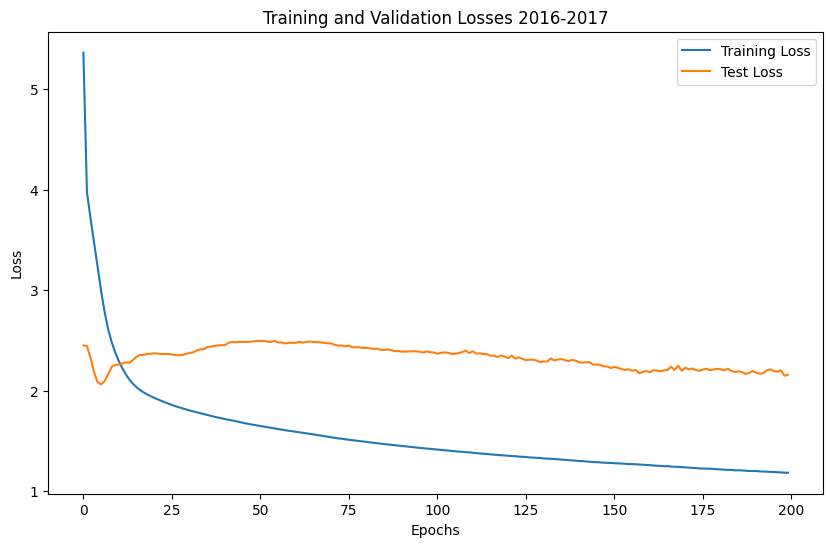

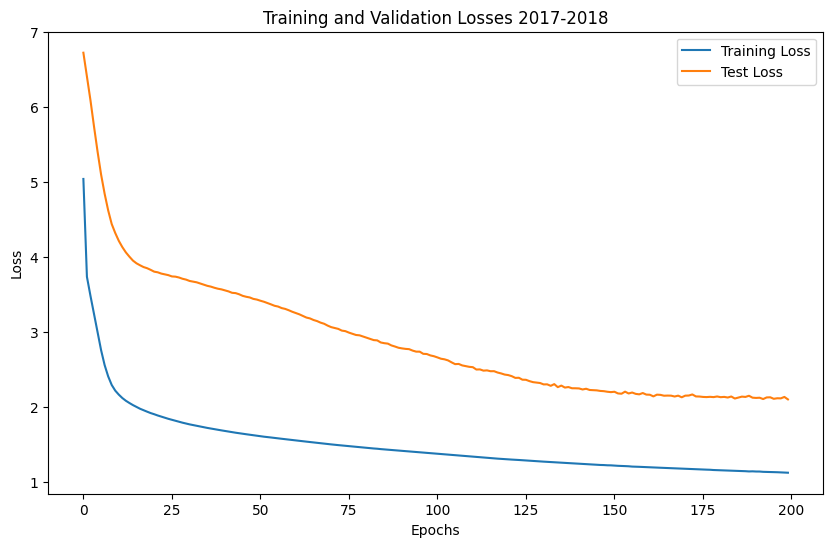

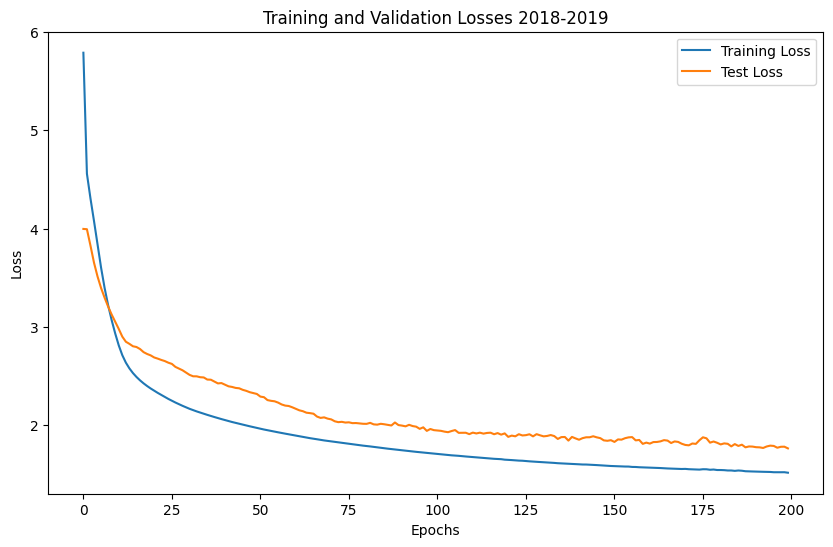

        Year      MAE          Pearson_Correlation               MAPE  \
                 mean      std                mean      std      mean   
0  2014-2015  1.54223  0.96030             0.95229  0.00151  26.76681   
1  2015-2016  1.59088  0.05735             0.93643  0.00160  21.84885   
2  2016-2017  2.18570  0.16445             0.93775  0.00321  49.86659   
3  2017-2018  2.16106  0.24391             0.98367  0.00277  22.47493   
4  2018-2019  1.80030  0.97798             0.95287  0.01061  43.45615   
5    Average  1.85604  0.27415             0.95267  0.00239  32.88267   

             
        std  
0  18.49531  
1   1.26406  
2   9.09758  
3   4.38790  
4  24.84639  
5   6.61270  


In [8]:
query_similarities = pd.read_csv('../fyp_data/average.csv').iloc[:1000]['Query'].to_list()
model_performance, model_predictions = run_neural_network(query_similarities, threshold=0.3)
# model_performance.to_csv('../results/ffnn_14_lagged/forecasting_t+7_performance.csv', index=False)
# model_predictions.to_csv('../results/ffnn_14_lagged/forecasting_t+7_predictions.csv', index=False)
print(model_performance)